# Scattering from a sphere using a combined direct formulation

### Background

In this tutorial, we will solve the problem of scattering from the unit sphere $\Omega$ using a combined integral formulation and an incident wave defined by

$$
u^{\text{inc}}(\mathbf x) = \mathrm{e}^{\mathrm{i} k x}.
$$

where $\mathbf x = (x, y, z)$.

The PDE is given by the Helmholtz equation:

$$
\Delta u + k^2 u = 0, \quad \text{ in } \mathbb{R}^3 \backslash \Omega,
$$

where $u=u^\text{s}+u^\text{inc}$ is the total acoustic field and $u^\text{s}$ satisfies the Sommerfeld radiation condition

$$
\frac{\partial u^\text{s}}{\partial r}-\mathrm{i}ku^\text{s}=o(r^{-1})
$$

for $r:=|\mathbf{x}|\rightarrow\infty$.

From Green's representation formula, one can derive that

$$
u(\mathbf x) = u^\text{inc}-\int_{\Gamma}g(\mathbf x,\mathbf y)\frac{\partial u}{\partial\nu}(\mathbf y)\mathrm{d}\mathbf{y}.
$$

Here, $g(\mathbf x, \mathbf y)$ is the acoustic Green's function given by

$$
g(\mathbf x, \mathbf y):=\frac{\mathrm{e}^{\mathrm{i} k |\mathbf{x}-\mathbf{y}|}}{4 \pi |\mathbf{x}-\mathbf{y}|}.
$$

The problem has therefore been reduced to computing the normal derivative $u_\nu:=\frac{\partial u}{\partial\nu}$ on the boundary $\Gamma$. This is achieved using the following boundary integral equation formulation.

$$
(\tfrac12\mathsf{Id} + \mathsf{K}' - \mathrm{i} \eta \mathsf{V}) u_\nu(\mathbf{x}) = \frac{\partial u^{\text{inc}}}{\partial \nu}(\mathbf{x}) - \mathrm{i} \eta u^{\text{inc}}(\mathbf{x}), \quad \mathbf{x} \in \Gamma.
$$

where $\mathsf{Id}$, $\mathsf{K}'$ and $\mathsf{V}$ are identity, adjoint double layer and single layer <a href='https://bempp.com/2017/07/11/available_operators/'>boundary operators</a>. More details of the derivation of this formulation and its properties can be found in the article <a href='http://journals.cambridge.org/action/displayAbstract?fromPage=online&aid=8539370&fileId=S0962492912000037' target='new'>Chandler-Wilde <em>et al</em> (2012)</a>.


### Implementation

First we import the Bempp module and NumPy.

In [13]:
import bempp.api
import numpy as np

#bempp.api.GLOBAL_PARAMETERS.ifgf.order=5
bempp.api.GLOBAL_PARAMETERS.ifgf.tol=1e-5
bempp.api.GLOBAL_PARAMETERS.ifgf.leaf_size=800
bempp.api.GLOBAL_PARAMETERS.ifgf.n_elements=1

bempp.api.enable_console_logging('debug')



<StreamHandler stderr (DEBUG)>

We define the wavenumber

In [14]:
k = 32.

The following command creates a sphere mesh.

In [15]:
grid = bempp.api.shapes.regular_sphere(5)

bempp:HOST:INFO: Created grid with id c62fd720-d4b5-496a-83ea-009f7eb80462. Elements: 8192. Edges: 12288. Vertices: 4098
bempp:HOST:TIMING: Grid.__init__ : 5.684e-02s


As basis functions, we use piecewise constant functions over the elements of the mesh. The corresponding space is initialised as follows.

In [16]:
piecewise_const_space = bempp.api.function_space(grid, "DP", 0)

bempp:HOST:TIMING: p0_discontinuous_function_space : 3.293e-03s


We now initialise the <a href='https://bempp.com/2017/07/11/operators/'>boundary operators</a>.
A boundary operator always takes at least three space arguments: a domain space, a range space and the test space (dual to the range). In this example we only work on the space $\mathcal{L}^2(\Gamma)$ and we can choose all spaces to be identical.

In [17]:
identity = bempp.api.operators.boundary.sparse.identity(
    piecewise_const_space, piecewise_const_space, piecewise_const_space)
adlp = bempp.api.operators.boundary.helmholtz.adjoint_double_layer(
    piecewise_const_space, piecewise_const_space, piecewise_const_space, k,assembler="ifgf")
slp = bempp.api.operators.boundary.helmholtz.single_layer(
    piecewise_const_space, piecewise_const_space, piecewise_const_space, k,assembler="ifgf")

ifgf!
ifgf!


Standard arithmetic operators can be used to create linear combinations of boundary operators.

In [18]:
lhs = 0.5 * identity + adlp - 1j * k * slp

We now form the right-hand side by defining a <a href='https://bempp.com/2017/07/11/grid-functions/'>GridFunction</a> using Python callable.

In [19]:
@bempp.api.complex_callable
def combined_data(x, n, domain_index, result):
    result[0] = 1j * k * np.exp(1j * k * x[0]) * (n[0]-1)

grid_fun = bempp.api.GridFunction(piecewise_const_space, fun=combined_data)

We can now use GMRES to solve the problem.

In [20]:
from bempp.api.linalg import gmres
neumann_fun, info,it,res = gmres(lhs, grid_fun, tol=1E-5, return_iteration_count=True,return_residuals=True) 

bempp:HOST:TIMING: Start operation: 
bempp:HOST:TIMING: Finished Operation: : 0.002344369888305664s
bempp:HOST:TIMING: assemble_sparse : 4.322e-03s
/home/arieder/.local/lib/python3.10/site-packages/pyopencl/__init__.py:272: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "
bempp:HOST:TIMING: Start operation: Singular assembler:helmholtz_adjoint_double_layer_boundary:opencl
bempp:HOST:TIMING: Finished Operation: Singular assembler:helmholtz_adjoint_double_layer_boundary:opencl: 0.24296975135803223s
bempp:HOST:TIMING: Start operation: Singular assembler:helmholtz_single_layer_boundary:opencl
bempp:HOST:TIMING: Finished Operation: Singular assembler:helmholtz_single_layer_boundary:opencl: 0.20886707305908203s
bempp:HOST:INFO: Starting GMRES iteration
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


init 1
creating new ifgf operator. n_leaf=800 order= 5 n_elements=1
building a new octree49152, 49152
finding bbox


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 896.0986819267273s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0052356719970703125s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 896.1067354679108s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


bbox=-0.999905 -0.999905 -0.999905	0.999905 0.999905 0.999905
sorting...
building the nodes up to level4
estimating the order needed to achieve 1e-05
new chebnodes
new chebnodes
new chebnodes
new chebnodes
new chebnodes
new chebnodes
using order=7
calculating interp range
n= 19  57 114
box=1.79769e+308 1.79769e+308 1.79769e+308 -1.79769e+308 -1.79769e+308 -1.79769e+308 1
n=10 30 60
box=0.536071 0.869383 0.696959 0.537831  1.00014 0.873838 0
n= 5 15 30
box=0.273403 0.799505 -1.50437 0.502484  2.91229  0.93294 0
n= 3  9 18
box=  0.122231 0.00645754   -3.14158 0.46336 2.42407 3.14158 0
interp_domain:       0        0 -3.14159 0.537831  3.14133  3.14159
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
init 2
creating new ifgf operator. n_leaf=800 order= 5 n_elements=1


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 897.6458823680878s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0053822994232177734s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 897.6539416313171s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


building a new octree49152, 49152
finding bbox
bbox=-0.999905 -0.999905 -0.999905	0.999905 0.999905 0.999905
sorting...
building the nodes up to level4
estimating the order needed to achieve 1e-05
using order=7
calculating interp range
n= 19  57 114
box=1.79769e+308 1.79769e+308 1.79769e+308 -1.79769e+308 -1.79769e+308 -1.79769e+308 1
n=10 30 60
box=0.536071 0.869383 0.696959 0.537831  1.00014 0.873838 0
n= 5 15 30
box=0.273403 0.799505 0.637856 0.502484  2.91229  3.07517 0
n= 3  9 18
box=0.124621 0.474818 -3.14159 0.457709  3.10931  3.14158 0
interp_domain:       0        0 -3.14159 0.537831  3.14133  3.14159
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
init 3
creating new ifgf operator. n_leaf=800 order= 5 n_elements=1


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 865.7382471561432s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005654573440551758s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 865.7462389469147s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


building a new octree49152, 49152
finding bbox
bbox=-0.999905 -0.999905 -0.999905	0.999905 0.999905 0.999905
sorting...
building the nodes up to level4
estimating the order needed to achieve 1e-05
using order=7
calculating interp range
n= 19  57 114
box=1.79769e+308 1.79769e+308 1.79769e+308 -1.79769e+308 -1.79769e+308 -1.79769e+308 1
n=10 30 60
box=0.536071 0.869383 0.696959 0.537831  1.00014 0.873838 0
n= 5 15 30
box=0.273403 0.229307 -1.50437 0.502484  2.34209  0.93294 0
n= 3  9 18
box=0.127718  0.61193 -3.14157  0.4082 3.13776 3.14158 0
interp_domain:       0        0 -3.14159 0.537831  3.14133  3.14159
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
init 0
creating new ifgf operator. n_leaf=800 order= 5 n_elements=1


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 235.42690205574036s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004921674728393555s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 235.43416047096252s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


building a new octree49152, 49152
finding bbox
bbox=-0.999905 -0.999905 -0.999905	0.999905 0.999905 0.999905
sorting...
building the nodes up to level4
estimating the order needed to achieve 1e-05
using order=5
calculating interp range
n= 26  78 156
box=1.79769e+308 1.79769e+308 1.79769e+308 -1.79769e+308 -1.79769e+308 -1.79769e+308 1
n=13 39 78
box=0.536071 0.869383 0.696959 0.537831  1.00014 0.873838 0
n= 7 21 42
box=  0.273403 0.00098991   -3.14152 0.502484  1.52379   3.1415 0
n= 4 12 24
box=  0.122231 0.00645754   -3.14159 0.46336 2.42407 3.14156 0
interp_domain:       0        0 -3.14159 0.537831   3.1406  3.14159
mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1

bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.488067150115967s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0049936771392822266s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.495793581008911s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.593281984329224s


starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004883289337158203s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.600889444351196s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.636362314224243s


starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.00490117073059082s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.643937349319458s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.97702431678772s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004969120025634766s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.984317779541016s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.5153489112854s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004691600799560547s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.52226996421814s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.615927934646606s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004777669906616211s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.623135328292847s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.162121295928955s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004918098449707031s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.170012950897217s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.720900535583496s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0046880245208740234s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.728011846542358s
bempp:HOST:INFO: GMRES Iteration 1 with residual 0.4195827239161947
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.804637670516968s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004735708236694336s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.811676502227783s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.801259517669678s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0048828125s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.80846619606018s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.577364206314087s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004959821701049805s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.584754228591919s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.877792835235596s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0052337646484375s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.885560989379883s
bempp:HOST:INFO: GMRES Iteration 2 with residual 0.21066085481435953
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 9.953311920166016s


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005567073822021484s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 9.961523294448853s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.26663064956665s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005157470703125s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.274375200271606s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.604056596755981s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.00496220588684082s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.611977577209473s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.770940542221069s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.00493931770324707s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.778317213058472s
bempp:HOST:INFO: GMRES Iteration 3 with residual 0.10673046045581343
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.295873403549194s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0047931671142578125s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.302963733673096s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.420705795288086s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005684852600097656s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.428686380386353s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.826689958572388s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005224943161010742s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.834323406219482s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.707571506500244s


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.00478053092956543s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.715071678161621s
bempp:HOST:INFO: GMRES Iteration 4 with residual 0.05977697598381615
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.699582576751709s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005296468734741211s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.707165718078613s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.659390449523926s


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005075693130493164s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.667075395584106s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.594852447509766s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004915714263916016s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.60172176361084s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.602910757064819s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005042314529418945s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.610367059707642s
bempp:HOST:INFO: GMRES Iteration 5 with residual 0.0373736204597314
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.429062128067017s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005421638488769531s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.436893463134766s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.482383966445923s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004962921142578125s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.48980164527893s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.364738702774048s


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004871845245361328s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.372153759002686s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult5
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.70428991317749s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0049402713775634766s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.711717367172241s
bempp:HOST:INFO: GMRES Iteration 6 with residual 0.023637319508501536
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.324919939041138s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004792451858520508s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.332109689712524s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
starting singular correction
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.48961877822876s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004922628402709961s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.497158765792847s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.612366914749146s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0048923492431640625s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.620029926300049s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.88349723815918s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004888057708740234s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.890805244445801s
bempp:HOST:INFO: GMRES Iteration 7 with residual 0.015007998958215807
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.210017681121826s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005018472671508789s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.217416524887085s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
starting singular correction
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.460655450820923s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004948616027832031s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.468060970306396s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.689536809921265s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0050678253173828125s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.697112321853638s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.609002351760864s


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004887819290161133s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.6164045333862305s
bempp:HOST:INFO: GMRES Iteration 8 with residual 0.009319154188748945
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.608490467071533s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005313873291015625s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.615864038467407s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.224019527435303s


starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005015373229980469s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.231797933578491s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.439924955368042s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0050618648529052734s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.447164297103882s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.847339868545532s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004865884780883789s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.854147672653198s
bempp:HOST:INFO: GMRES Iteration 9 with residual 0.0058562540593796
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.104422092437744s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005007028579711914s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.111653089523315s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.4780855178833s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0048770904541015625s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.485087633132935s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.47905421257019s


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0062999725341796875s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.487884759902954s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.851978063583374s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004713296890258789s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.8588666915893555s
bempp:HOST:INFO: GMRES Iteration 10 with residual 0.0037957230055379767
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.264673709869385s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005093812942504883s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.27208685874939s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.530633211135864s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0049550533294677734s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.53834080696106s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.588465929031372s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.007359981536865234s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.598396062850952s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 7.434760093688965s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0049245357513427734s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 7.442356109619141s
bempp:HOST:INFO: GMRES Iteration 11 with residual 0.002426150750588864
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.391348600387573s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005424022674560547s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.399687767028809s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.440630435943604s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0049664974212646484s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.448134899139404s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.572303056716919s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0048329830169677734s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.579373121261597s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.844825506210327s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0049724578857421875s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.852078676223755s
bempp:HOST:INFO: GMRES Iteration 12 with residual 0.001581990201951167
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.707900285720825s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005404472351074219s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.715729475021362s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.607332229614258s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004719257354736328s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.61436128616333s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.612195491790771s


starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004844188690185547s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.619751930236816s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.978057622909546s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005312204360961914s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.98577618598938s
bempp:HOST:INFO: GMRES Iteration 13 with residual 0.0010354401915790281
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.599274635314941s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005469799041748047s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.607446193695068s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.109034538269043s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004981040954589844s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.116473913192749s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.668892621994019s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0060482025146484375s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.677414655685425s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.353204011917114s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0048296451568603516s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.360315561294556s
bempp:HOST:INFO: GMRES Iteration 14 with residual 0.0006659075419360523
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.421162366867065s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005301952362060547s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.42907190322876s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.543940305709839s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005293846130371094s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.551619291305542s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.535985946655273s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0050890445709228516s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.543387651443481s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 7.128655672073364s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005082845687866211s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 7.136130094528198s
bempp:HOST:INFO: GMRES Iteration 15 with residual 0.0004439070831284158
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 9.996275424957275s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0050907135009765625s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.003694534301758s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.448106288909912s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004962444305419922s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.455411672592163s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.409284114837646s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005125999450683594s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.417053937911987s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.675320148468018s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004948616027832031s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.682389259338379s
bempp:HOST:INFO: GMRES Iteration 16 with residual 0.00029807105930700555
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.632938146591187s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005287885665893555s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.640758275985718s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.267245292663574s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0048618316650390625s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.274863004684448s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.615401029586792s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0053217411041259766s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.623042106628418s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.748598337173462s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0050547122955322266s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.756021499633789s
bempp:HOST:INFO: GMRES Iteration 17 with residual 0.00020083168272024202
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.68013620376587s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004763126373291016s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.68709921836853s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.546385049819946s


starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005047321319580078s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.554167032241821s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.816171884536743s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.00481104850769043s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.823523759841919s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.71834135055542s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.00506901741027832s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.7257890701293945s
bempp:HOST:INFO: GMRES Iteration 18 with residual 0.00013501189862164564
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.401719808578491s


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0053920745849609375s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.410244941711426s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.502282857894897s


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004915952682495117s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.51020884513855s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.594357252120972s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004800319671630859s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.60150408744812s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.60566782951355s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0053195953369140625s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.61337685585022s
bempp:HOST:INFO: GMRES Iteration 19 with residual 9.313260733568413e-05
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.387326717376709s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005017757415771484s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.394940376281738s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
starting singular correction
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.425620794296265s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004825592041015625s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.432873487472534s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.295673608779907s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005110502243041992s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.303695440292358s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 7.635364294052124s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0050373077392578125s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 7.642867565155029s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.824223756790161s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004994869232177734s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.831975936889648s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.322134017944336s


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004830598831176758s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.329630851745605s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.644511222839355s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004984855651855469s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.652676343917847s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.559686899185181s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.00491023063659668s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.567030191421509s
bempp:HOST:INFO: GMRES Iteration 20 with residual 6.449891454718892e-05
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.376476526260376s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005602836608886719s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.384681940078735s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.411690950393677s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0048558712005615234s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.419103860855103s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.251943588256836s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0049326419830322266s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.259237051010132s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.524668216705322s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.00513005256652832s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.531905174255371s
bempp:HOST:INFO: GMRES Iteration 21 with residual 4.6986965119094215e-05
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.584900140762329s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004958152770996094s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.592221975326538s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.359474420547485s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0048732757568359375s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.366747617721558s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.528142929077148s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004846096038818359s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.53555965423584s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.675178050994873s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0049250125885009766s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.682905197143555s
bempp:HOST:INFO: GMRES Iteration 22 with residual 3.5535430391753816e-05
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.495989799499512s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004848957061767578s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.5036780834198s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.353637456893921s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004872798919677734s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.360981225967407s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.285871028900146s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0048673152923583984s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.293319702148438s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.646270513534546s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004914045333862305s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.653757333755493s
bempp:HOST:INFO: GMRES Iteration 23 with residual 2.6333274465742153e-05
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.382659196853638s


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004841327667236328s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.390154600143433s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.306687116622925s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0050618648529052734s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.314188957214355s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.610694169998169s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0058743953704833984s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.61852478981018s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.49588942527771s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004978656768798828s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.502830505371094s
bempp:HOST:INFO: GMRES Iteration 24 with residual 1.9366351327423446e-05
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.9254150390625s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005404472351074219s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.933388948440552s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.
bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.369135618209839s


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004911661148071289s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.37680435180664s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.288267135620117s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004834890365600586s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.295416593551636s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 7.047793626785278s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.00509333610534668s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 7.055151462554932s
bempp:HOST:INFO: GMRES Iteration 25 with residual 1.3817521911415942e-05
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult7
permutation


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 11.722886562347412s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005129814147949219s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 11.730292558670044s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.425723552703857s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.0049896240234375s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.433181762695312s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
starting singular correction
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
done with singular corrections


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 10.657814264297485s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.005089521408081055s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 10.665071487426758s
bempp:HOST:TIMING: Start operation: Evaluating ifgf.
bempp:HOST:TIMING: Start operation: Calling IFGF.


mult7
permutation
boxes=120
base size 2  6 12
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done
starting singular correction
done with singular corrections
mult5
permutation
boxes=120
base size 3  9 18
now go
doing recursive at level2
now proceeding iteratively1
level=1
step 1
step 2
step 3
level=0
step 1
step 2
done


bempp:HOST:TIMING: Finished Operation: Calling IFGF.: 6.671464920043945s
bempp:HOST:TIMING: Start operation: Singular Corrections Evaluator
bempp:HOST:TIMING: Finished Operation: Singular Corrections Evaluator: 0.004966259002685547s
bempp:HOST:TIMING: Finished Operation: Evaluating ifgf.: 6.678489923477173s
bempp:HOST:INFO: GMRES Iteration 26 with residual 9.741942022892274e-06
bempp:HOST:INFO: GMRES finished in 26 iterations and took 3.98E+03 sec.


starting singular correction
done with singular corrections


`gmres` returns a grid function `neumann_fun` and an integer `info`. When everything works fine info is equal to 0.

At this stage, we have the surface solution of the integral equation. Now we will evaluate the solution in the domain of interest. We define the evaluation points as follows.

In [10]:
Nx = 200
Ny = 200
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))
u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)
u_evaluated[:] = np.nan

This will generate a grid of points in the $x$-$y$ plane.

Then we create a single layer potential operator and use it to evaluate the solution at the evaluation points. The variable ``idx`` allows to compute the solution only at points located outside the unit circle of the plane. We use a single layer potential operator to evaluate the solution at the observation points.

In [11]:
x, y, z = points
idx = np.sqrt(x**2 + y**2) > 1.0

from bempp.api.operators.potential import helmholtz as helmholtz_potential
slp_pot = helmholtz_potential.single_layer(
    piecewise_const_space, points[:, idx], k)
res = np.real(np.exp(1j *k * points[0, idx]) - slp_pot.evaluate(neumann_fun))
u_evaluated[idx] = res.flat

We now plot the slice of the domain solution.

Text(0.5, 1.0, 'Scattering from the unit sphere, solution in plane z=0')

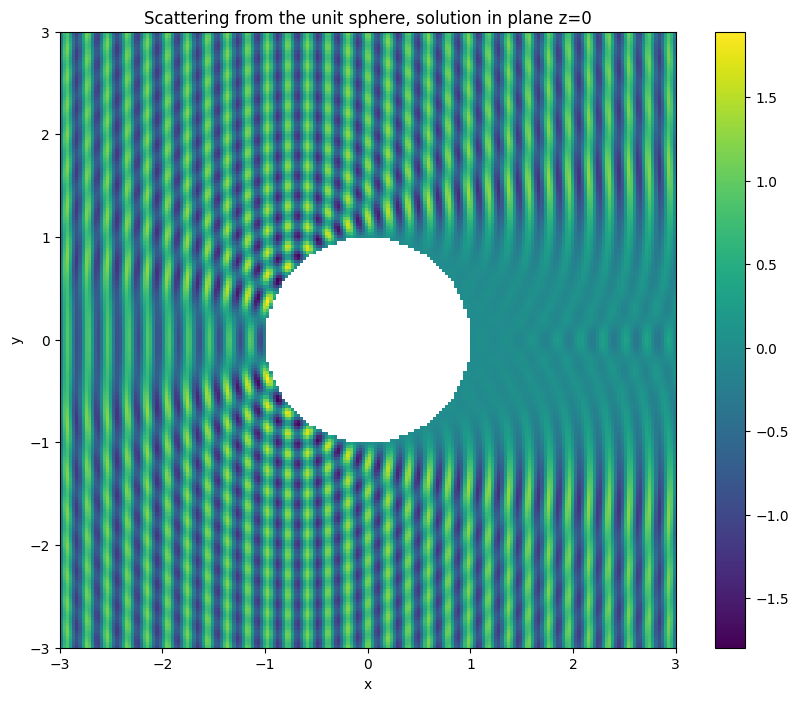

In [12]:
%matplotlib inline

u_evaluated = u_evaluated.reshape((Nx, Ny))

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(u_evaluated.T), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Scattering from the unit sphere, solution in plane z=0")